<img src="https://github.com/insaid2018/Term-1/blob/master/Images/INSAID_Full%20Logo.png?raw=true" width="240" height="360" />

## ML Term 4 Project - Store Item Sales Demand Forecast
### TIME SERIES ANALYSIS - ARIMA 

- By : Anitha Chandrakesan

## Table of contents
1. [Objective](#Objective)
2. [Data Loading and Visualization](#Data Loading and Visualization)
3. [Stationarity Check](#Stationarity Check)
4. [Decomposition](#Decomposition) 
5. [Data Transformation to achieve Stationarity](#Data Transformation to achieve Stationarity)
6. [Plotting ACF & PACF](#Plotting ACF & PACF)
7. [Train Test split and Building Models](#Building ARIMA Model)
8. [Test the model](#Test)
9. [Conclusion](#Conclusion)


### 1. Objective <a name = "Objective"></a>
- Build a model to forecast the demand of item sales in a Store.
- The data is classified in date and sales each day of every item in each store

### 2. Data Loading and Visualization <a name = "Data Loading and Visualization"></a>

### Import Libraries

In [4]:
import pandas as pd 
import numpy as np
import matplotlib.pylab as plt 
%matplotlib inline   
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')


### Load Dataset

In [6]:
dataset  =  pd.read_csv('https://raw.githubusercontent.com/insaid2018/Term-3/master/Projects/Store_Item_demand_forecast.csv')
dataset.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [7]:
dataset.shape

(913000, 4)

In [8]:
dataset.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

No Null Values in dataset

In [9]:
dataset.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [10]:
#overview of data
print("number of different items: %i" %(len(np.unique(dataset.item))))
print("number of different stores: %i" %(len(np.unique(dataset.store))))
print("number of different dates: %i" %(len(np.unique(dataset.date))))
print("maximun date in data: %s" %(max(dataset.date)))
print("minimum date in data: %s" %(min(dataset.date)))


number of different items: 50
number of different stores: 10
number of different dates: 1826
maximun date in data: 2017-12-31
minimum date in data: 2013-01-01


__Visualizing the dataset__

1. Distribution of Sales

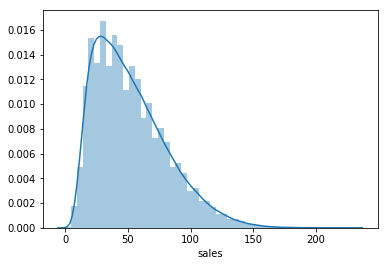

In [11]:
sns.distplot(dataset["sales"])

In [12]:
dataset['weekday']=pd.DatetimeIndex(dataset['date']).weekday
dataset['month']=pd.DatetimeIndex(dataset['date']).month 
dataset['year']=pd.DatetimeIndex(dataset['date']).year

Most Of the sales of item is around 40

2. Comparing Annual sales between stores

<Figure size 1080x720 with 0 Axes>

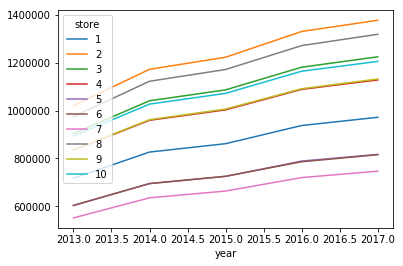

In [13]:
#we check anual sales profile comparing stores
c=dataset.groupby(['year','store']).sum()
plt.figure(figsize=(15,10))
d=c.unstack()
d.plot(y='sales')

We can see there is upward Trend in the data from the year 2013 to 2017


3. Comparing Monthly sales between stores

<Figure size 1080x720 with 0 Axes>

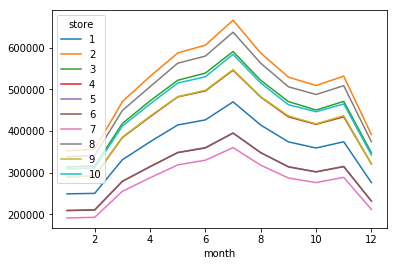

In [14]:
#we check seasonal sales profile comparing stores
c=dataset.groupby(['month', 'store']).sum()
plt.figure(figsize=(15,10))
d=c.unstack()
d.plot(y='sales')

We can observe that there is more sales in the month of July

4. Comparing Weekly sales between stores


<Figure size 1080x720 with 0 Axes>

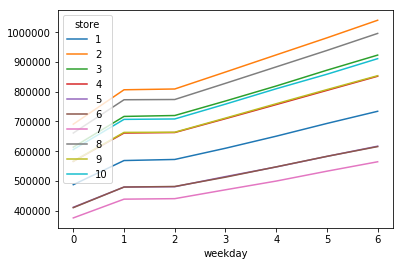

In [15]:
#we check anual sales profile comparing stores
c=dataset.groupby(['weekday','store']).sum()
plt.figure(figsize=(15,10))
d=c.unstack()
d.plot(y='sales')

In [16]:
dataset.drop(columns=["year","month","weekday"],inplace=True)
dataset.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


We will now analyse Store 1 and Item 1

In [17]:
store1item1 = dataset.loc[(dataset['store'] == 1) & (dataset['item'] == 1)]
store1item1.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [18]:
store1item1.shape

(1826, 4)

In [19]:
store1item1['date']  =  pd.to_datetime(store1item1['date'],infer_datetime_format = True)             #convert from string to datetime

indexedDataset  =  store1item1.set_index(['date'])
indexedDataset= indexedDataset.drop(columns=["store","item"])
indexedDataset.head(5)

,sales
date,
2013-01-01,13
2013-01-02,11
2013-01-03,14
2013-01-04,13
2013-01-05,10


In [20]:
indexedDataset.shape

(1826, 1)

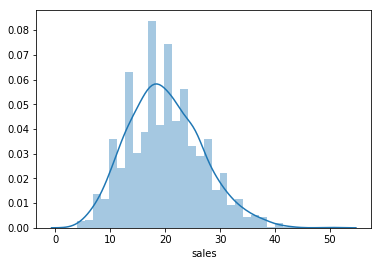

In [21]:
sns.distplot(indexedDataset["sales"])

### 3. Stationarity Check <a name = "Stationarity Check"></a>

In [22]:
# Determine rolling statistics
def rolling_means(time_series):
    rolmean  =  time_series.rolling(window = 12).mean()    #window size 12 denotes 12 months, giving rolling mean at yearly level
    rolstd  =  time_series.rolling(window = 12).std()

    orig  =  plt.plot(time_series, color = 'blue', label = 'Original')
    mean  =  plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    std  =  plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block = False)

In [23]:
#Perform Augmented Dickey–Fuller test:
def adf_test(time_series):
    
    from statsmodels.tsa.stattools import adfuller
    dftest  =  adfuller(time_series, autolag = 'AIC')

    dfoutput  =  pd.Series(dftest[0:4], index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        
        dfoutput['Critical Value (%s)'%key]  =  value
    
    print('Results of Dickey Fuller Test:') 
    print(dfoutput)
    


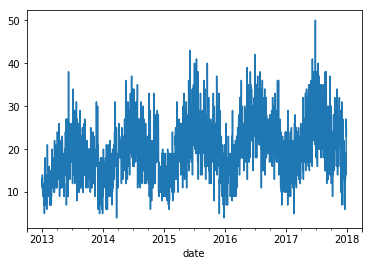

In [24]:
indexedDataset['sales'].plot()

### 4. Decomposition <a name = "Decomposition"></a>

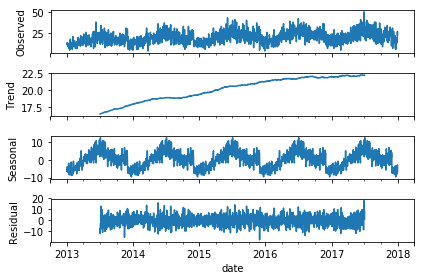

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose
fig = seasonal_decompose(indexedDataset['sales'], model='additive', freq=365).plot()

From the plot above, we can see that there is a __Trend compoenent__ and __seasonal component__ in the series.<br/> 

We will check stationarity using both __rolling statistics plot and ADF test__.

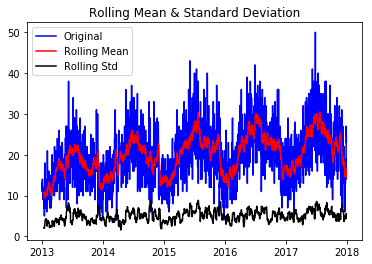

In [26]:
rolling_means(indexedDataset["sales"])

In [27]:
adf_test(indexedDataset['sales'])

Results of Dickey Fuller Test:
Test Statistic                   -3.157671
p-value                           0.022569
#Lags Used                       23.000000
Number of Observations Used    1802.000000
Critical Value (1%)              -3.433984
Critical Value (5%)              -2.863145
Critical Value (10%)             -2.567625
dtype: float64


The Dickey-Fuller test the time series is not considered stationary as Test Statistic greater than 1% Critical Value and we can see visually that there is an upwards trend.

### 5. Data Transformation to achieve Stationarity <a name = "Data Transformation to achieve Stationarity"></a>


Try to make the data __Stationary__ we will try

1. Log scale transform
2. Log Scale Minus Moving Average
3. Exponential Decay
4. Shift Difference

### log scale transform

In [28]:
#log scale transform
import numpy as np
indexedDataset_logScale  =  np.log(indexedDataset)

In [29]:
adf_test(indexedDataset_logScale.sales)

Results of Dickey Fuller Test:
Test Statistic                   -3.594424
p-value                           0.005869
#Lags Used                       23.000000
Number of Observations Used    1802.000000
Critical Value (1%)              -3.433984
Critical Value (5%)              -2.863145
Critical Value (10%)             -2.567625
dtype: float64


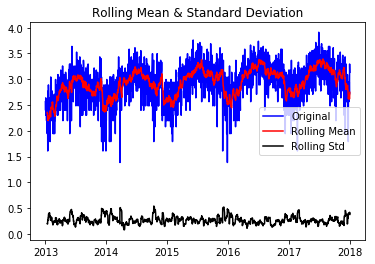

In [30]:
rolling_means(indexedDataset_logScale)

Dataset is still non stationary

### Log Scale Minus Moving Average

In [31]:
movingAverage  =  indexedDataset_logScale.rolling(window = 12).mean()
datasetLogScaleMinusMovingAverage  =  indexedDataset_logScale - movingAverage

#Remove NAN values
datasetLogScaleMinusMovingAverage.dropna(inplace = True)


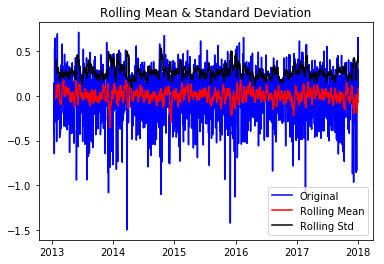

In [32]:
rolling_means(datasetLogScaleMinusMovingAverage)

In [33]:
adf_test(datasetLogScaleMinusMovingAverage.sales)

Results of Dickey Fuller Test:
Test Statistic                -1.031707e+01
p-value                        3.077488e-18
#Lags Used                     2.000000e+01
Number of Observations Used    1.794000e+03
Critical Value (1%)           -3.434000e+00
Critical Value (5%)           -2.863152e+00
Critical Value (10%)          -2.567628e+00
dtype: float64


Data is somewhat stationary

### Exponential Decay Weighted Average

In [34]:
exponentialDecayWeightedAverage  =  indexedDataset_logScale.ewm(halflife = 12, min_periods = 0, adjust = True).mean()

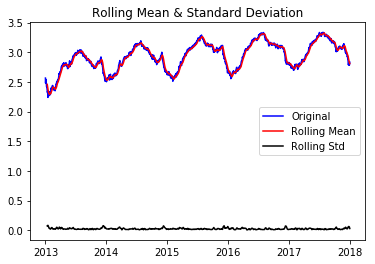

In [35]:
rolling_means(exponentialDecayWeightedAverage)

In [36]:
adf_test(exponentialDecayWeightedAverage.sales)

Results of Dickey Fuller Test:
Test Statistic                   -3.666915
p-value                           0.004603
#Lags Used                       24.000000
Number of Observations Used    1801.000000
Critical Value (1%)              -3.433986
Critical Value (5%)              -2.863146
Critical Value (10%)             -2.567625
dtype: float64


### Log Scale Shifting

In [37]:
datasetLogDiffShifting  =  indexedDataset_logScale - indexedDataset_logScale.shift()

In [38]:
datasetLogDiffShifting.dropna(inplace = True)

In [39]:
datasetLogDiffShifting.head()

,sales
date,
2013-01-02,-0.167054
2013-01-03,0.241162
2013-01-04,-0.074108
2013-01-05,-0.262364
2013-01-06,0.182322


In [40]:
adf_test(datasetLogDiffShifting.sales)

Results of Dickey Fuller Test:
Test Statistic                -1.259629e+01
p-value                        1.775858e-23
#Lags Used                     2.200000e+01
Number of Observations Used    1.802000e+03
Critical Value (1%)           -3.433984e+00
Critical Value (5%)           -2.863145e+00
Critical Value (10%)          -2.567625e+00
dtype: float64


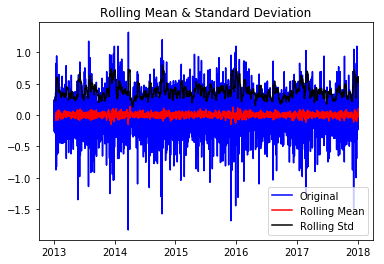

In [41]:
rolling_means(datasetLogDiffShifting)

the p-value is extremely small. Thus this series is very likely to be stationary.

### Data is now Stationary

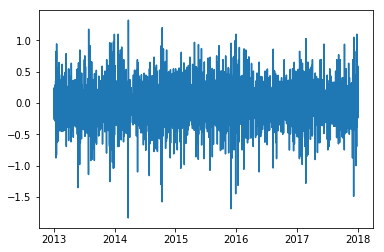

In [42]:
plt.plot(datasetLogDiffShifting)

### 6. Plotting ACF & PACF <a name = "Plotting ACF & PACF"></a>

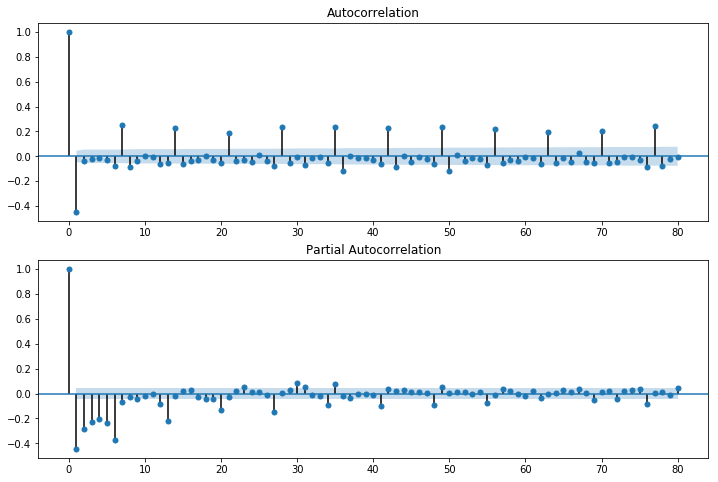

In [43]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(datasetLogDiffShifting.sales, lags=80, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = plot_pacf(datasetLogDiffShifting.sales, lags=80, ax=ax2)


P, Q value - 7

Here we can see the acf and pacf both has a recurring pattern every 7 periods. Indicating a weekly pattern exists. 

### 7. Train Test split and Building ARIMA Model <a name = "Building ARIMA Model"></a> 

In [44]:
datasetLogDiffShifting.shape

(1825, 1)

In [45]:
# Data Preparation
#testing last 100 days
train, test = datasetLogDiffShifting[0:len(datasetLogDiffShifting)-100], datasetLogDiffShifting[len(datasetLogDiffShifting)-100:]
train.head()


,sales
date,
2013-01-02,-0.167054
2013-01-03,0.241162
2013-01-04,-0.074108
2013-01-05,-0.262364
2013-01-06,0.182322


In [46]:
test.head()

,sales
date,
2017-09-23,0.278713
2017-09-24,-0.432864
2017-09-25,-0.538997
2017-09-26,0.251314
2017-09-27,0.405465


In [47]:
test.tail()

,sales
date,
2017-12-27,-0.133531
2017-12-28,0.305382
2017-12-29,-0.236389
2017-12-30,0.587787
2017-12-31,-0.160343


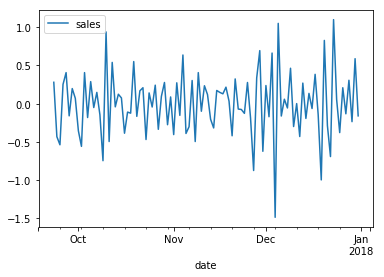

In [48]:
test.plot()

In [49]:
print(train.shape)
print(test.shape)

(1725, 1)
(100, 1)


In [50]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA (train, order=(7,0,7))
model_fit = model.fit()
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  sales   No. Observations:                 1725
Model:                     ARMA(7, 7)   Log Likelihood                -122.205
Method:                       css-mle   S.D. of innovations              0.256
Date:                Tue, 19 Mar 2019   AIC                            276.409
Time:                        20:50:33   BIC                            363.657
Sample:                    01-02-2013   HQIC                           308.685
                         - 09-22-2017                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0004        nan        nan        nan         nan         nan
ar.L1.sales    -0.9815        nan        nan        nan         nan         nan
ar.L2.sales    -0.9798        nan        nan    

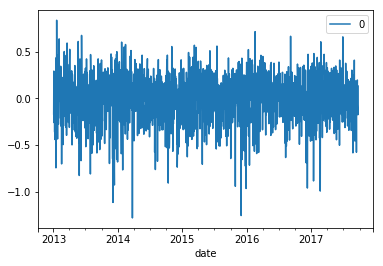

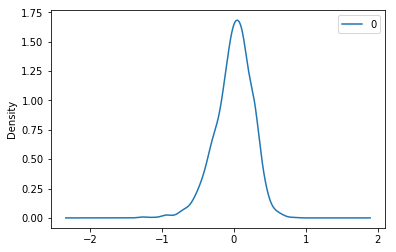

                 0
count  1725.000000
mean     -0.000406
std       0.258482
min      -1.281093
25%      -0.148300
50%       0.021333
75%       0.172674
max       0.837585


In [60]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [52]:
model_fit.fittedvalues.head()

date
2013-01-02    0.000409
2013-01-03   -0.051842
2013-01-04    0.185016
2013-01-05   -0.047085
2013-01-06    0.051539
dtype: float64

In [53]:
print(train.shape)
print(model_fit.fittedvalues.shape)

(1725, 1)
(1725,)


In [54]:
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
error = mean_squared_error(train, model_fit.fittedvalues)
print('Train MSE: %.3f' % error)

Train MSE: 0.067


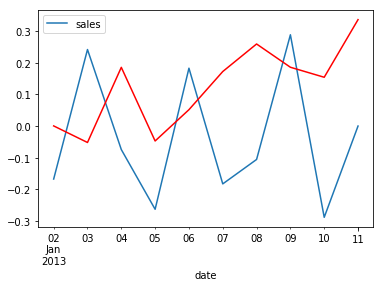

In [55]:
train.head(10).plot()
model_fit.fittedvalues.head(10).plot(color='red')



### 8. Test Model <a name = "Test"></a>

In [56]:
# make predictions
predictions = model_fit.predict(start=len(train), end=len(datasetLogDiffShifting)-1, dynamic=False)

In [57]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot results

Test MSE: 0.134


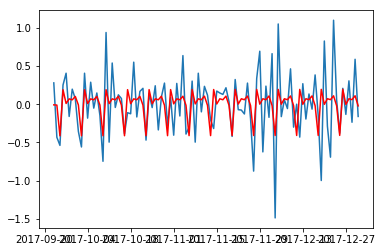

In [58]:
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

### 9. Conclusion <a name = "Conclusion"></a>

We have built a model to forecast the demand of item 1 sales in a Store 1  </br><br>
Using ARIMA model with P value and Q value 7 </br>
Since we observed the acf and pacf both has a recurring pattern every 7 periods. Indicating a weekly pattern exists.
